# Convolution
There are multiple ways for convolving images using pyclesperanto - intentionally. We will compare their performance to each other and also to an implementation in scikit-image.

See also: https://en.wikipedia.org/wiki/Convolution

Let's start by initializing the GPU

In [1]:
import pyclesperanto_prototype as cle
from skimage import filters
from skimage.morphology import ball
import time

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

<GeForce RTX 2070 on Platform: NVIDIA CUDA (1 refs)>

## Convolution kernel
To visualize the weights used by the convolution to multiply pixels with surrounding pixel values, we create an image with a single pixel set to 1 (all others are 0) and convolve it. The resulting `kernel` image is also called the `structuring element`.

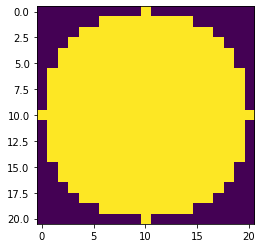

In [2]:
def create_kernel(radius = 10):

    diameter = radius * 2 + 1
    spot = cle.create([diameter, diameter])
    cle.set(spot, 0)
    cle.draw_box(spot, radius, radius, 0, 0, 0, 0)

    kernel = cle.create([diameter, diameter])
    cle.mean_sphere(spot, kernel, radius, radius)

    return kernel

kernel = create_kernel(10)
cle.imshow(kernel)

We now generate an image with random pixel values to convolve it

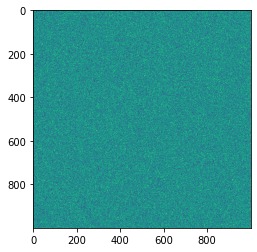

In [3]:
import numpy as np

test_image = cle.push(np.random.random([1000, 1000]))

cle.imshow(test_image)                        

## Quick benchmarking different convolution strategies
We start by convolving the image with the kernel created above

In [4]:
kernel = create_kernel(10)

import time
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.convolve(test_image, kernel, result_image)
    print("Convolve custom duration: " + str(time.time() - start_time))

Convolve custom duration: 0.006981611251831055
Convolve custom duration: 0.0029916763305664062
Convolve custom duration: 0.002989530563354492
Convolve custom duration: 0.0029921531677246094
Convolve custom duration: 0.0029909610748291016
Convolve custom duration: 0.002992868423461914
Convolve custom duration: 0.002992391586303711
Convolve custom duration: 0.0029921531677246094
Convolve custom duration: 0.0029916763305664062
Convolve custom duration: 0.002990245819091797


Another strategy is calling the mean_sphere function. This means, we don't us a kernel image internally.

In [5]:
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.mean_sphere(test_image, result_image, 10, 10)
    print("Convolve sphere duration: " + str(time.time() - start_time))

Convolve sphere duration: 0.004986763000488281
Convolve sphere duration: 0.004985332489013672
Convolve sphere duration: 0.003988981246948242
Convolve sphere duration: 0.003986835479736328
Convolve sphere duration: 0.003989696502685547
Convolve sphere duration: 0.0049839019775390625
Convolve sphere duration: 0.004991292953491211
Convolve sphere duration: 0.003987550735473633
Convolve sphere duration: 0.003986835479736328
Convolve sphere duration: 0.004986286163330078


A faster version uses mean_box. Note: The structuring element is a rectangle, and not a sphere anymore. This operation is typically faster because this is a separable implementation.

In [6]:
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.mean_box(test_image, result_image, 10, 10)
    print("Convolve box duration: " + str(time.time() - start_time))

Convolve box duration: 0.00698089599609375
Convolve box duration: 0.002989530563354492
Convolve box duration: 0.002991914749145508
Convolve box duration: 0.0029959678649902344
Convolve box duration: 0.00299072265625
Convolve box duration: 0.0029947757720947266
Convolve box duration: 0.002986907958984375
Convolve box duration: 0.002996683120727539
Convolve box duration: 0.0029904842376708984
Convolve box duration: 0.002994060516357422


# Convolution in 3D

In [7]:
def create_kernel_3d(radius = 10):

    diameter = radius * 2 + 1
    spot = cle.create([diameter, diameter, diameter])
    cle.set(spot, 0)
    cle.draw_box(spot, radius, radius, radius, 0, 0, 0)

    kernel = cle.create([diameter, diameter, diameter])
    cle.mean_sphere(spot, kernel, radius, radius, radius)

    return kernel

kernel = create_kernel_3d(2)
kernel

array([[[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.03030303, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.03030303, 0.03030303, 0.03030303, 0.        ],
        [0.        , 0.03030303, 0.03030303, 0.03030303, 0.        ],
        [0.        , 0.03030303, 0.03030303, 0.03030303, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.03030303, 0.        , 0.        ],
        [0.        , 0.03030303, 0.03030303, 0.03030303, 0.        ],
        [0.03030303, 0.03030303, 0.03030303, 0.03030303, 0.03030303],
        [0.        , 0.03030303, 0.03030303, 0.03030303, 0.        ],
        [0.     

## Quick benchmarking different convolution strategies in 3D
We start by convolving the image with the kernel created above

In [8]:
import numpy as np

test_image = cle.push_zyx(np.random.random([100, 100, 100]))
                     

In [9]:
kernel = create_kernel_3d(10)

import time
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.convolve(test_image, kernel, result_image)
    print("Convolve custom duration: " + str(time.time() - start_time))

Convolve custom duration: 0.06682157516479492
Convolve custom duration: 0.06083536148071289
Convolve custom duration: 0.05086231231689453
Convolve custom duration: 0.051862478256225586
Convolve custom duration: 0.05185818672180176
Convolve custom duration: 0.05285978317260742
Convolve custom duration: 0.05185890197753906
Convolve custom duration: 0.0528559684753418
Convolve custom duration: 0.05286002159118652
Convolve custom duration: 0.052855491638183594


Another strategy is calling the mean_sphere function. This means, we don't us a kernel image internally.

In [10]:
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.mean_sphere(test_image, result_image, 10, 10, 10)
    print("Convolve sphere duration: " + str(time.time() - start_time))

Convolve sphere duration: 0.04741215705871582
Convolve sphere duration: 0.04587531089782715
Convolve sphere duration: 0.04587697982788086
Convolve sphere duration: 0.04587745666503906
Convolve sphere duration: 0.045874834060668945
Convolve sphere duration: 0.04687929153442383
Convolve sphere duration: 0.04581880569458008
Convolve sphere duration: 0.044886112213134766
Convolve sphere duration: 0.045905351638793945
Convolve sphere duration: 0.04549527168273926


A faster version uses mean_box. Note: The structuring element is a rectangle, and not a sphere anymore. This operation is typically faster because this is a separable implementation.

In [11]:
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.mean_box(test_image, result_image, 10, 10, 10)
    print("Convolve box duration: " + str(time.time() - start_time))

Convolve box duration: 0.02706146240234375
Convolve box duration: 0.0038940906524658203
Convolve box duration: 0.0034389495849609375
Convolve box duration: 0.003582000732421875
Convolve box duration: 0.003453969955444336
Convolve box duration: 0.0039038658142089844
Convolve box duration: 0.0032875537872314453
Convolve box duration: 0.003624439239501953
Convolve box duration: 0.003353118896484375
Convolve box duration: 0.0037848949432373047


## Mean filter in scikit-image

In [12]:
# mean filter with scikit-image
result_image = None
structuring_element = ball(10)

for i in range(0, 10):
    start_time = time.time()
    result_image = filters.rank.mean(test_image, selem=structuring_element, out=result_image)
    print("skimage rank.mean duration: " + str(time.time() - start_time))

c:\users\rober\miniconda3\lib\site-packages\skimage\filters\rank\generic.py:278: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image, selem, out, mask, n_bins = _handle_input_3D(image, selem, out, mask,


skimage rank.mean duration: 34.42355275154114
skimage rank.mean duration: 33.18763279914856
skimage rank.mean duration: 32.87314820289612
skimage rank.mean duration: 33.66009593009949
skimage rank.mean duration: 37.38083744049072
skimage rank.mean duration: 35.021158933639526
skimage rank.mean duration: 34.05577373504639
skimage rank.mean duration: 35.13659048080444
skimage rank.mean duration: 34.86917328834534
skimage rank.mean duration: 35.529059410095215
